In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='43ac9a2a-82d2-4db1-983f-d72a8d684183', project_access_token='p-2+FRv4NKKFeDt7myvMPr+Q3w==;s+jfBgy1g9qXB1uZ3zf3Pg==:ACI47GaP9EQC597m/j0uTmOVcg3Q83pzuaAmGiWYFgM9m7jRzhQc/dcdvcew8xdWj/42b36x7OGonH73cAF+SfQhtfqWYli0Ow==')
pc = project.project_context

from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space({'token':'p-2+FRv4NKKFeDt7myvMPr+Q3w==;s+jfBgy1g9qXB1uZ3zf3Pg==:ACI47GaP9EQC597m/j0uTmOVcg3Q83pzuaAmGiWYFgM9m7jRzhQc/dcdvcew8xdWj/42b36x7OGonH73cAF+SfQhtfqWYli0Ow=='})



# RAG Function Log Analysis and Feedback Evaluation with Topic Modeling
Version 1.2<br><br>
Use this notebook to gain insights into user's feedback.<br><br>
This notebook implements log data retrieval, data preparation, topic modeling and correlation analysis.<br>
It forms a basis for feedback analysics and is intented to be enhanced by more functions.


## Content
This notebook contains the following parts:
- [Import Log Records](#ImportLogRecords)
- [Map Feedback to Percentage](#MapFeedbackToPercentage)
- [Rating Distribution](#RatingDistribution)
- [Topic Modeling](#TopicModeling)
- [Score by Topic](#ScoreByTopic)
- [Score by Response Length](#ScoreByResponseLength)
- [Document Search Score by Topic](#DocumentSearchScoreByTopic)

## Topic Modeling
Topic modeling is a key feature of this analysis notebook. It is an unsupervised learning technique that clusters a set of text documents into groups by detecting common word and phrase pattern. Each group is represented by a topic, which is a set of keywords that appear to be relevant in the belonging documents. Depending on its keywords affinity, a topic might appear explicit or somewhat abstract.
Two models for topic modelling are supported:
* ### Watson NLP
A hierarchical topic model that supports a lot of tuning options, in particular stop word optimization.
* ### BERTopic
A model based on transformers and c-TF-IDF with few tuning options but very good out-of-the-box performance.

Watson NLP is used if all conditions below are met. Otherwise BERTopic is installed and used.
* Parameter `use_watson_nlp` is set to `true` or set to `false` or not set at all in the `RAG_advanced_parameter_set`.
* Python module `watson_nlp` is available. On IBM Cloud, this notebook must run in an appropriate environment ("NLP + DO runtime...").


## Pre-Requisite Libraries and Dependencies
Download and import mandatory libraries and dependencies

In [2]:
!pip install --upgrade elasticsearch | tail -n 1
!pip install wordcloud | tail -n 1

In [3]:
from elasticsearch import Elasticsearch, helpers
from wordcloud import WordCloud
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
from matplotlib.colors import hsv_to_rgb, TABLEAU_COLORS

## Import Parameter Set and Helper Functions

In [4]:
parameter_sets = ["RAG_parameter_set"]
parameters={}
for parameter_set in parameter_sets:
    parameter_vals= wslib.assets.get_asset(parameter_set, "parameter_set", raw=True)
    if 'entity' in parameter_vals and 'parameter_set' in parameter_vals['entity'] and 'parameters' in parameter_vals['entity']['parameter_set']:
        parameter_vals = parameter_vals['entity']
    params = {param['name']: param['value'] for param in parameter_vals['parameter_set']['parameters']}
    parameters.update(params)  

In [5]:
try:
    filename = 'rag_helper_functions.py'
    wslib.download_file(filename)
    import rag_helper_functions
    print("rag_helper_functions imported from the project assets")
except NameError as e:
    print(str(e))
    print("If running watsonx.ai aaS on IBM Cloud, check that the first cell in the notebook contains a project token. If not, select the vertical ellipsis button from the notebook toolbar and `insert project token`. Also check that you have specified your ibm_api_key in the second code cell of the notebook")

rag_helper_functions imported from the project assets


<a id="ImportLogRecords"></a>
## Import Log Records
Read log records from Elasticsearch index. Use query to filter retrieved records, see examples in comments below.

In [6]:
# Read all log records
query = {"match_all": {}}

# Read log records older than a day
#query = {"range": {"log_timestamp": {"lte": "now-1d/d"}}}

In [7]:
if not 'log_elastic_search_index_name' in parameters or parameters['log_elastic_search_index_name'] == '':
    print(f"Log index is not specified.")
    raise
else:
    log_elastic_search_index_name = parameters['log_elastic_search_index_name']
    log_connection_name=parameters["log_elastic_search_connection_asset"]
    if(next((conn for conn in wslib.list_connections() if conn['name'] == log_connection_name), None)):
        log_es_connection = wslib.get_connection(log_connection_name)
        print("Successfully retrieved the log connection details.")
    else:
        log_es_connection = {key[19:]: parameters[key] for key in parameters.keys() if key.startswith('log_elastic_search_')}
        print("Log connection credentials read from parameter set.")
    try:
        log_es_client = rag_helper_functions.create_elastic_client(log_es_connection)
        log_es_response = helpers.scan(
            log_es_client, 
            index = log_elastic_search_index_name,
            query = {"query": query, "_source": ["question", "response", "feedback", "source_documents.score"]}
    )
    except:
        print(f"Cannot read data from index {log_elastic_search_index_name}.")
        raise
        
    data = pd.DataFrame().from_dict([dict(item)['_source'] for item in log_es_response])
    print(f"{str(len(data))} log records read.")

Successfully retrieved the log connection details.
Reading from the connection..
Connecting to Elastic Search using Elastic Search URL and API key.
Succesfully connected to elasticsearch
39 log records read.


<a id="MapFeedbackToPercentage"></a>
## Map Feedback to Percentage
Map the user rating to a percentage by linear interpolation. Best rating maps to 100%, worst rating maps to 0%. If no feedback is given, rating percentage is -1.

In [8]:
# Thumb up, thumb down rating
supported_ratings = ['positive', 'negative']

# 5 rating options
#supported_ratings = ['perfect', 'good', 'ok', 'bad', 'very bad']

In [9]:
rating_count = len(supported_ratings)
rating_percentage = {supported_ratings[i]: int(100.5 - i * (100 / (rating_count-1))) for i in range(rating_count)} | {'n/a': -1}
rating_options = list(rating_percentage.keys())
rating_percentage

{'positive': 100, 'negative': 0, 'n/a': -1}

In [10]:
data['eval_rating_percent'] = data['feedback'].map(lambda val: -1 if not isinstance(val, dict) or not 'value' in val else 
    int(val['value']) if val['value'].isnumeric() else 
    rating_percentage[val['value']] if val['value'] in rating_options else
    -1 )

In [11]:
data['eval_rating'] = data['eval_rating_percent'].map(lambda val: \
    rating_options[len([v for v in [rating_percentage[rating] for rating in rating_percentage.keys()] if v > val])])

## Colors
Calculate colors for ratings using HSV (hue, saturation, value) format. Loop on hue from 33% (green) to 0% (red) and on value from 0.6 to 1 to 0.6 (sinus curve).<br>
A color is calculated for each rating option, including lightgray for "no feedback".

In [12]:
rating_color = [hsv_to_rgb((0.33 * (x/(rating_count-1)), 1, 0.6 + 0.4 * math.sin((x/(rating_count-1)) * math.pi))) for x in range(rating_count-1, -1, -1)] + ["lightgray"]

<a id="RatingDistribution"></a>
## Rating Distribution
Number of user rates by rating option.<br>
Shows the rating distribution, "n/a" for records without feedback (often the largest number). 

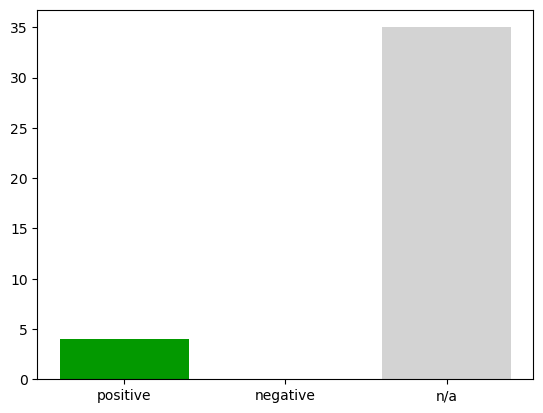

In [13]:
distribution = data['eval_rating'].value_counts()
distribution = {key: distribution[key] if key in distribution.keys() else 0 for key in rating_options}
plt.bar(distribution.keys(), distribution.values(), color = rating_color)
plt.show()

<a id="TopicModeling"></a>
## Topic Modeling
Topic modeling can be done on user questions and/or on RAG function responses.<br>
Topic modeling on user questions might be less valuable due to shorter texts and deviate questions.<br>
Topic modeling on RAG function responses cannot find topics that are asked for by the user but not part of the content database.

In [14]:
# Topic modeling on user questions
#evaluation_field = 'question'

# Topic modeling on RAG function responses
evaluation_field = 'response'

### Watson NLP
Topic detection with Watson NLP. To optimize detected topic, add words to `stopwords` that appear in your log records on various subjects and are therefore not beneficial for topic separation. 

In [15]:
use_waton_nlp = ('use_watson_nlp' not in parameters or parameters['use_watson_nlp'].lower() == 'true')
if not use_waton_nlp:
    print(f"Watson NLP not used: Disabled by parameter setting.")
else:
    try:
        import watson_nlp
        from watson_nlp.toolkit.summary_utils import NGramSummary
        from watson_nlp.blocks.topics import HierarchicalClustering
        from watson_core import data_model as dm
    except:
        print(f"Watson NLP not used: Watson NLP not available in runtime.")
        use_waton_nlp = False

if use_waton_nlp:

   
    eval_df = pd.DataFrame(data[evaluation_field])
    train_file = './TMP_train_data.csv'
    eval_df.to_csv(train_file)

    # load the syntax model
    syntax_model = watson_nlp.load('syntax_izumo_en_stock')

    csv_stream = dm.DataStream.from_csv(train_file, skip=1)
    syntax_data = syntax_model.stream(csv_stream[1])

    wnlp_stopwords = watson_nlp.load('text_stopwords_classification_ensemble_en_stock').stopwords
    stopwords = list(wnlp_stopwords)
    stopwords.extend(["create","add","delete","select", "find", "click","go","app","allow",'type', 'based', 'base', 'provided', 'answer', 'question', 'following', 'information'])
    # words that do not separate topics in actual business context, adjust to meet your needs
    #stopwords.extend(['transaction', 'report', 'program', 'code', 'reference', 'business', 'document', 'data', 'date'])

    summary_model = NGramSummary.train(train_data=syntax_data, train_params={
        'min_words_per_utterance': 5,
        'num_turns_to_remove': 0,
        'beginning_ratio': 1,
        'beginning_weighting_factor': 5,
        'min_ngram_size': 2,
        'max_ngram_size': 3,
        'max_ngrams': 50,
        'stopwords': list(stopwords)
    })

    topic_model = HierarchicalClustering.train(train_data=syntax_data, summary_model=summary_model, train_params = {
        'king_cluster_min_ratio': 1.5, 
        'min_records_per_king_cluster': 10 + int(len(eval_df) / 50),
        'num_topics_per_iteration': 10, 
        'max_num_iters_per_model': 4, 
        'max_ngrams_per_topic': 10
    })

    topics_list = sorted(topic_model.model.to_json_summary()['clusters'], key=lambda t: t['numDocuments'], reverse=True)

    keywords_list = {}
    for _t in topics_list:
        keywords = {s.split(',')[0].split('(')[0].strip(): float(s.split(',')[-1]) for s in _t['modelWords']}
        if _t['topicName'] in keywords_list:
            keywords_list[_t['topicName']] = keywords_list[_t['topicName']] | keywords
        else:
            keywords_list[_t['topicName']] = keywords
        
    topicnames = {i: name for i, name in enumerate(keywords_list.keys())} | {-1: 'unknown'}
    topicnames_reverse = {topicnames[key]: key for key in topicnames.keys()}

    def extract(item):
        return topicnames_reverse[item.topics[0].name] if len(item.topics) > 0 and item.topics[0].name in topicnames_reverse else -1
    data['eval_topic'] = data[evaluation_field].map(lambda r: extract(topic_model.run(syntax_model.run(r.strip()))))
    
    print(f"{str(len(topicnames)-1)} topics detected.")


10 topics detected.


### BERTopic
BERTopic creates clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.
Find information on BERTopic at https://maartengr.github.io/BERTopic/index.html.
The below cell detects stopwords, generates keywords (without stopwords) & topic names.

In [16]:
if not use_waton_nlp:
    !pip install --upgrade bertopic | tail -n 1
    
    from bertopic import BERTopic
    
    docs = data[evaluation_field].astype(str).values.tolist()
    if len(docs) < 1000:
        topic_model = BERTopic()
    else:
        topic_model = BERTopic(nr_topics='auto')
        
    topics, probs = topic_model.fit_transform(docs)
    topic_count = len(topic_model.get_topic_info())
    if topic_count < 1 or (topic_count == 1 and topic_model.get_topic(-1)):
        raise Exception("Topic modeling failed: No topic found.")
    if not topic_model.get_topic(-1):
        print(f"Warning: Detected topics might be poor.")
    else:
        print(f"{str(topic_count-1)} topics detected.")
        
    data['eval_topic'] = topics
    
    # Detected worlds that are not relevant for topic separation ("stopwords")
    stopwords = [w[0] for w in topic_model.get_topic(-1)] if topic_model.get_topic(-1) else []

    # Generate list of keywords (without stopwords) and frequencies
    keywords_list = {r[1]: {w[0]: w[1] for w in topic_model.get_topic(r[0]) if w[0] not in stopwords} for r in topic_model.get_topic_info().loc[:, ['Topic','Name']].values if not r[0] == -1}
    
    # Generate topic name from top 4 keywords
    topicnames = {int(topic.split('_')[0]): '_'.join([x for i,x in enumerate(keywords_list[topic].keys()) if i < 4]) for topic in keywords_list.keys()} | {-1: 'unknown'}

## Topic Keywords
For top 10 topics, plot keywords as wordcloud to visualize topic subject. Use this visualization to perceive the essence of the detected topics.

In [17]:
def plot_wordcloud_top10_topics(topicnames, keywords_list):
    colors = [color for name, color in TABLEAU_COLORS.items()]
    cloud = WordCloud(background_color='white', width=400, height=400, max_words=8, color_func=lambda *args, **kwargs: colors[i], prefer_horizontal=1.0)
    count = min(10,len(keywords_list))
    if count < 1:
        return
    
    # create and fill 2 x 5 grid of subplots with 10 word clouds
    figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(25,10), dpi=100, sharex=True, sharey=True)
    for i, topic in enumerate(zip(topicnames, keywords_list.keys())):
        if i >= count:
            break
        figure.add_subplot(axes[divmod(i,5)])
        topic_words = keywords_list[topic[1]]
        cloud.generate_from_frequencies(topic_words, max_font_size=72)
        plt.gca().imshow(cloud)
        plt.gca().set_title(f"{str(topic[0])}: {topicnames[topic[0]]}", fontdict=dict(size=16))
        
    # in case there are less than 10 topics, remove redundant subplots
    for i in range(count,10):
        axes[divmod(i,5)].remove()

    # adjust margins, remove ticks and show plot
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.show()

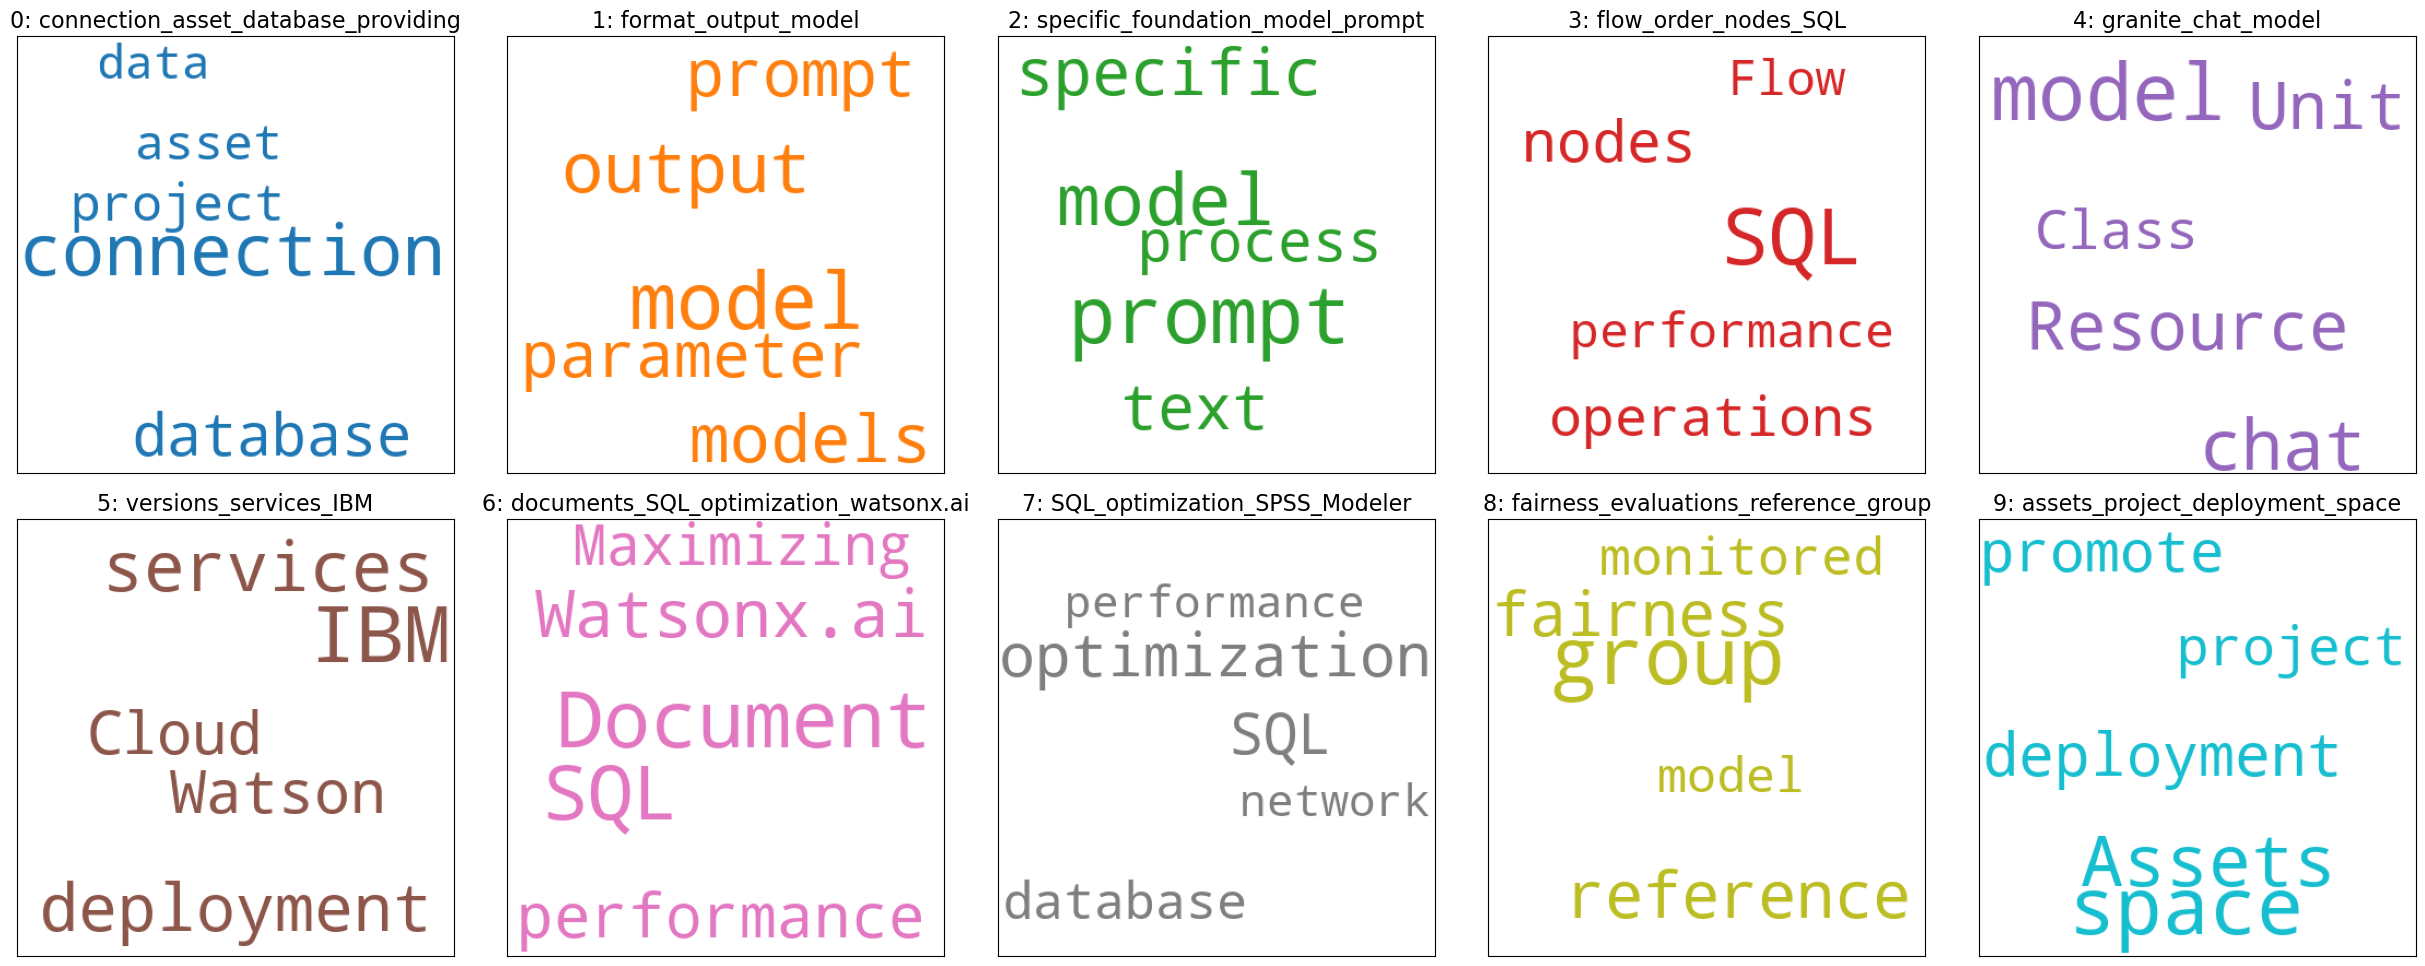

In [18]:
plot_wordcloud_top10_topics(topicnames, keywords_list)

<a id="ScoreByTopic"></a>
## Score by Topic
Find correlation between rating and topic.<br>
Poor rating on a topic indicates that content on that topic is bad or missing.

In [19]:
def displayName(title):
    return ' '.join([_t[0].upper() + (_t[1:] if len(_t) > 1 else '') for _t in title.replace('eval_','').replace('_', ' ').strip().split()]) 

In [20]:
def correlation_matrix(eval_column, row_order=None, index_mapper=None, totals=True):
    name = eval_column.replace('eval_','').replace('_', ' ')
    correlation_df = data.groupby([eval_column, 'eval_rating']).size().unstack(fill_value=0).reindex(index=row_order, columns=supported_ratings)
    if index_mapper:
         correlation_df.index = correlation_df.index.map(index_mapper)
    if totals:
        correlation_df.loc['Total'] = correlation_df.sum(numeric_only=True)
        
    title = f"Rating by {displayName(name)}"
    display(correlation_df)
    correlation_df.plot.bar(rot=90, stacked=True, color=rating_color, title=title, legend=True, xlabel='')
    
    title = f"\nRating by {displayName(name)} [Percentages]"
    correlation_df_percentage = correlation_df.div(correlation_df.sum(axis=1), axis=0).mul(100).round(1) 
    print(title)
    display(correlation_df_percentage)
    correlation_df_percentage.plot.bar(rot=90, stacked=True, color=rating_color, title=title, legend=False, xlabel='')

In [21]:
def score(eval_column, value_column='eval_rating_percent', rename=None, reindex=None):
    score_df = data[[eval_column, value_column]].groupby([eval_column]).mean()
    if rename:
        score_df = score_df.rename(index=rename)
    if reindex:
        score_df = score_df.reindex(reindex)
    score_df.plot.barh(title=f"{displayName(value_column)} by {displayName(eval_column)}", legend=False, xlabel='', ylabel='') 

eval_rating                            positive  negative
eval_topic                                               
unknown                                       0       NaN
connection_asset_database_providing           0       NaN
format_output_model                           0       NaN
specific_foundation_model_prompt              0       NaN
flow_order_nodes_SQL                          2       NaN
granite_chat_model                            0       NaN
versions_services_IBM                         0       NaN
documents_SQL_optimization_watsonx.ai         0       NaN
SQL_optimization_SPSS_Modeler                 2       NaN
fairness_evaluations_reference_group          0       NaN
assets_project_deployment_space               0       NaN


Rating by Topic [Percentages]


eval_rating                            positive  negative
eval_topic                                               
unknown                                     NaN       NaN
connection_asset_database_providing         NaN       NaN
format_output_model                         NaN       NaN
specific_foundation_model_prompt            NaN       NaN
flow_order_nodes_SQL                      100.0       NaN
granite_chat_model                          NaN       NaN
versions_services_IBM                       NaN       NaN
documents_SQL_optimization_watsonx.ai       NaN       NaN
SQL_optimization_SPSS_Modeler             100.0       NaN
fairness_evaluations_reference_group        NaN       NaN
assets_project_deployment_space             NaN       NaN

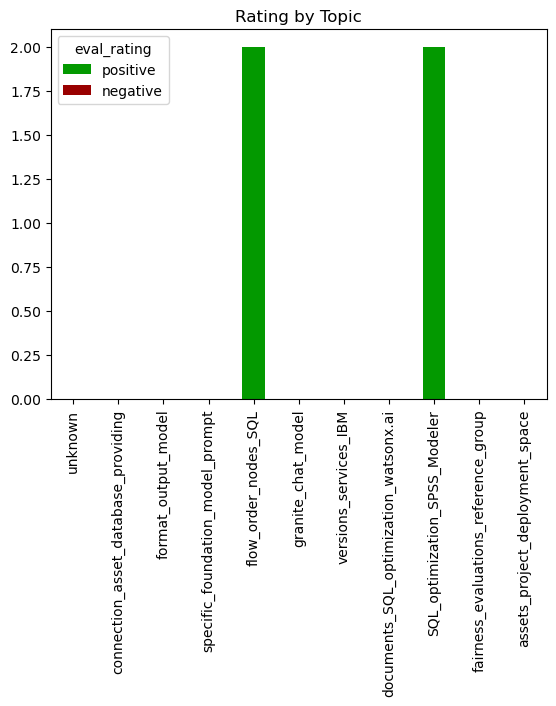

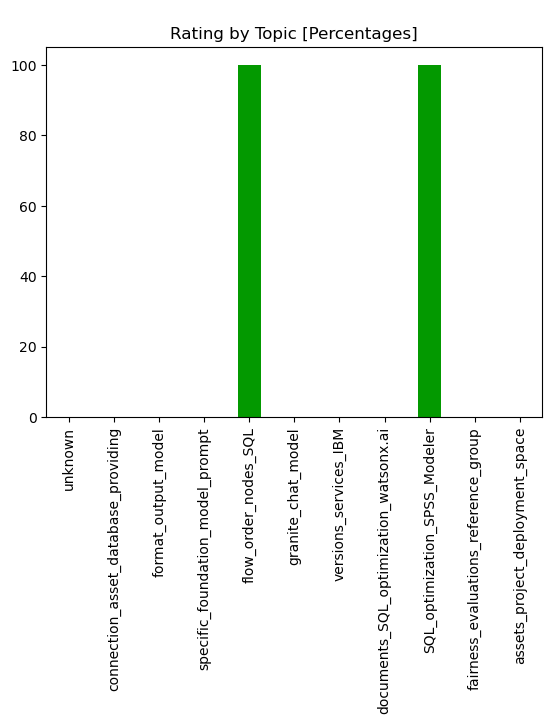

In [22]:
correlation_matrix('eval_topic', None, topicnames, False)

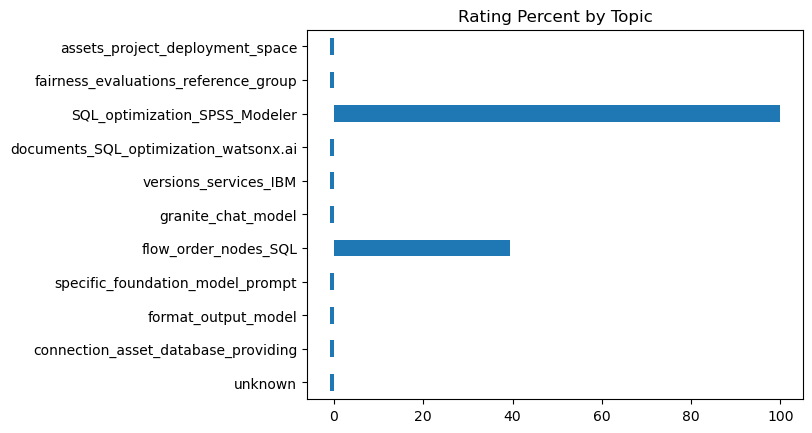

In [23]:
score('eval_topic', rename=topicnames)

<a id="ScoreByResponseLength"></a>
## Score by Response Length
Find correlation between rating and response length.<br>
Based on the result, model parameters can be adjusted to generate more or less tokens, respectively.

In [24]:
# Number of bins for histogram
number_of_bins = 10

In [25]:
# Count words in response
data['eval_words'] = data['response'].map(lambda txt: len(txt.split()))

In [26]:
# Calculate bin ranges and labels
hist, bins_raw = np.histogram(data['eval_words'], number_of_bins)
bins = [int(b+0.5) for b in bins_raw]
bins_labels = ['<'+str(bins[1])] + [str(bins[i])+'-'+str(bins[i+1]-1) for i in range(1,len(bins)-2)] + ['>='+str(bins[len(bins)-2])]

In [27]:
data['eval_words_bins'] = data['eval_words'].map(lambda x: bins_labels[len([v for v in bins[:-2] if v < x])])

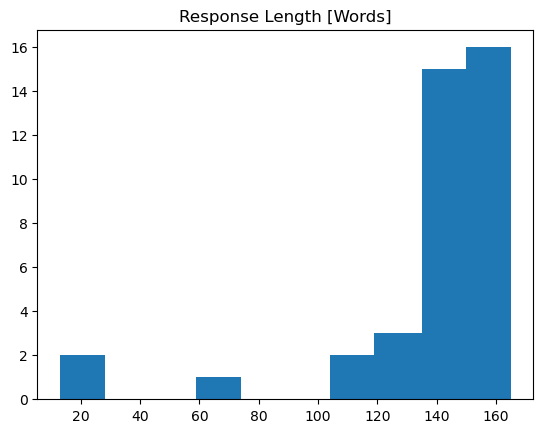

In [28]:
_ = plt.hist(data['eval_words'], bins=bins)
plt.title("Response Length [Words]")
plt.show()

eval_rating      positive  negative
eval_words_bins                    
<28                   0.0       NaN
28-42                 NaN       NaN
43-58                 NaN       NaN
59-73                 NaN       NaN
74-88                 0.0       NaN
89-103                NaN       NaN
104-118               NaN       NaN
119-134               0.0       NaN
135-149               0.0       NaN
>=150                 4.0       NaN


Rating by Words Bins [Percentages]


eval_rating      positive  negative
eval_words_bins                    
<28                   NaN       NaN
28-42                 NaN       NaN
43-58                 NaN       NaN
59-73                 NaN       NaN
74-88                 NaN       NaN
89-103                NaN       NaN
104-118               NaN       NaN
119-134               NaN       NaN
135-149               NaN       NaN
>=150               100.0       NaN

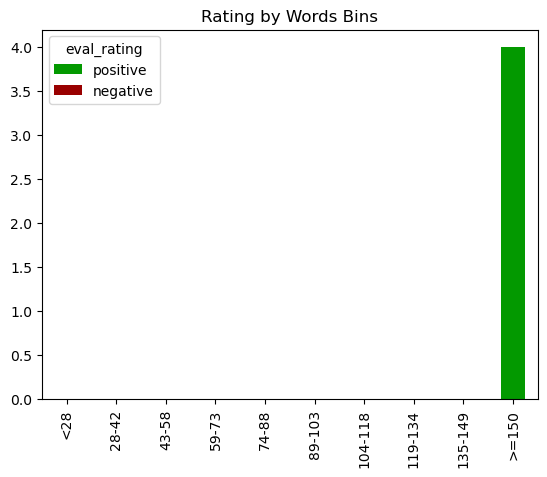

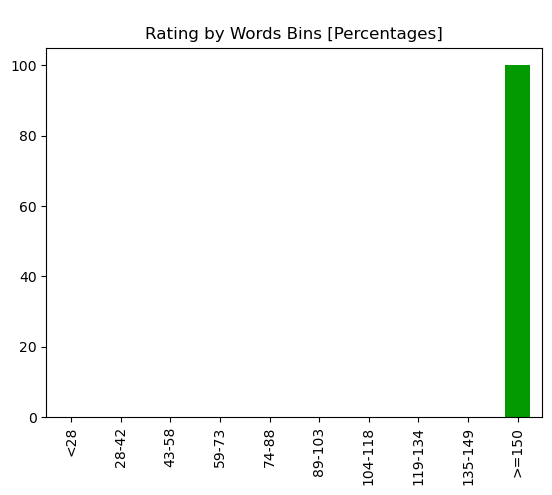

In [29]:
df = correlation_matrix('eval_words_bins', bins_labels, None, False)

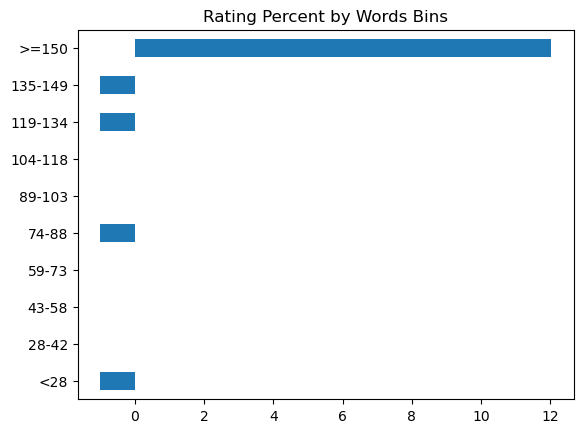

In [30]:
score('eval_words_bins', reindex=bins_labels)

<a id="DocumentSearchScoreByTopic"></a>
## Document Search Score by Topic
List document search score by topic. The document search score is the maximum search score over all source documents in a log record. Search score by topic is the average document search score over all queries or responses on that topic.<br>
A poor score indicates insufficient coverage of the corresponding topic within the content database.

In [31]:
if 'source_documents' in data:
    data['eval_search_score'] = data['source_documents'].map(lambda _scores: max([_s['score'] for _s in _scores]), na_action='ignore')
else:
    print(f"Document scores not available!")
    data['eval_search_score'] = 0

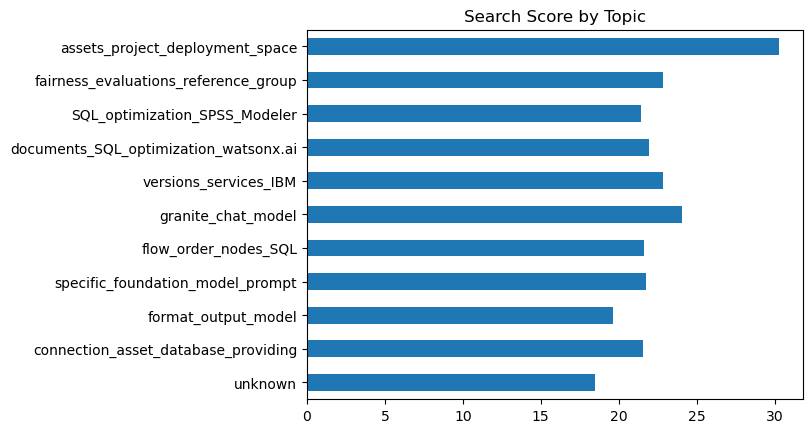

In [32]:
score('eval_topic', value_column='eval_search_score', rename=topicnames)

**Sample Materials, provided under license.</a> <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2024. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**